# <font color="red">U2OS VQ1 Codebook Hierarchical Clustering and Feature Spectra<font/>


In [1]:
import os
import sys

import scipy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, pearsonr

%matplotlib inline
%reload_ext autoreload
%autoreload 2
%aimport
warnings.filterwarnings('ignore')


Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
CYTOSELF_MODEL_PATH = '/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_cytoself_qsplit9/'
EMBEDDINGS_FOLDER = os.path.join(CYTOSELF_MODEL_PATH, 'embeddings', 'U2OS', 'vqindhist1', 'U2OS_spd_format')
SAVE_PATH = '/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/U2OS'

## Load vqindhist of U2OS cells

In [3]:
vqindhist = np.load(os.path.join(EMBEDDINGS_FOLDER,  'vqindhist1_allset.npy'))
labels = np.load(os.path.join(EMBEDDINGS_FOLDER, 'vqindhist1_labels_allset.npy'))
paths = np.load(os.path.join(EMBEDDINGS_FOLDER, 'vqindhist1_paths_allset.npy'))
        

print(vqindhist.shape, labels.shape)
print(np.unique(labels).shape)

(2715, 2048) (2715,)
(6,)


## Save the histograms in a dataframe (hist_df) and add the label

In [4]:
hist_df = pd.DataFrame(vqindhist)
hist_df['label'] = labels
hist_df['label'] = hist_df['label'].str.replace("_spd_format", "")
hist_df['label'] = hist_df['label'].str.replace(os.sep, "_")

def rearrange_string(s):
    parts = s.split('_')
    return f"{parts[4]}_{parts[1]}_{parts[2]}_{parts[0]}_{parts[3]}"

hist_df['label'] = hist_df['label'].apply(rearrange_string)
hist_df_with_path = hist_df.copy()
hist_df_with_path['path'] = paths


hist_df

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DCP1A_U2OS_stress_U2OS_rep1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DCP1A_U2OS_stress_U2OS_rep1
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DCP1A_U2OS_stress_U2OS_rep1
3,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DCP1A_U2OS_stress_U2OS_rep1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DCP1A_U2OS_stress_U2OS_rep1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,DCP1A_U2OS_stress_U2OS_rep1
2711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,DCP1A_U2OS_stress_U2OS_rep1
2712,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,DCP1A_U2OS_stress_U2OS_rep1
2713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,DCP1A_U2OS_stress_U2OS_rep1


In [5]:
print(f"Labels: {hist_df['label'].unique()} \n\n")


Labels: ['DCP1A_U2OS_stress_U2OS_rep1' 'DCP1A_U2OS_Untreated_U2OS_rep1'
 'Phalloidin_U2OS_stress_U2OS_rep1' 'G3BP1_U2OS_stress_U2OS_rep1'
 'G3BP1_U2OS_Untreated_U2OS_rep1' 'Phalloidin_U2OS_Untreated_U2OS_rep1'] 




## Average the histograms per each label and save in a new dataframe (mean_spectra_per_marker)

In [6]:
mean_spectra_per_marker = hist_df.groupby('label').mean()
mean_spectra_per_marker

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
label,,,,,,,,,,,,,,,,,,,,,
DCP1A_U2OS_Untreated_U2OS_rep1,0.373333,0.028889,0.168889,0.053333,0.044444,0.000000,0.028889,0.013333,0.044444,0.037778,...,0.015556,0.206667,0.008889,0.028889,0.020000,0.277778,0.071111,0.484444,0.002222,0.000000
DCP1A_U2OS_stress_U2OS_rep1,0.347253,0.030769,0.200000,0.043956,0.039560,0.000000,0.050549,0.013187,0.041758,0.032967,...,0.039560,0.125275,0.002198,0.015385,0.019780,0.153846,0.028571,0.892308,0.002198,0.000000
G3BP1_U2OS_Untreated_U2OS_rep1,0.513333,0.037778,0.137778,0.595556,0.242222,0.017778,0.486667,0.222222,0.904444,0.755556,...,0.122222,0.048889,0.040000,0.071111,0.040000,0.922222,0.002222,0.684444,0.006667,0.002222
G3BP1_U2OS_stress_U2OS_rep1,0.096703,0.041758,0.230769,0.120879,0.083516,0.008791,0.498901,0.109890,0.243956,0.573626,...,0.030769,0.079121,0.149451,0.026374,0.037363,0.797802,0.006593,0.793407,0.008791,0.000000
Phalloidin_U2OS_Untreated_U2OS_rep1,0.253333,0.137778,0.080000,0.393333,0.191111,0.020000,0.288889,0.382222,1.084444,0.828889,...,0.055556,0.268889,0.053333,0.168889,0.011111,0.524444,0.028889,0.506667,0.004444,0.002222
Phalloidin_U2OS_stress_U2OS_rep1,0.272527,0.107692,0.151648,0.406593,0.145055,0.015385,0.314286,0.347253,1.145055,0.835165,...,0.026374,0.021978,0.008791,0.063736,0.037363,0.393407,0.008791,0.468132,0.002198,0.000000


## Correlate the indices histograms

In [7]:
corr = mean_spectra_per_marker.corr()
corr

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.000000,-0.304079,-0.349691,0.401632,0.346651,0.010760,-0.218044,-0.097174,0.093144,-0.157177,...,0.624573,-0.072008,-0.679971,-0.012751,0.027838,-0.009550,0.153511,-0.081345,-0.317324,0.411400
1,-0.304079,1.000000,-0.731008,0.469494,0.482051,0.718076,0.174910,0.902351,0.799897,0.703173,...,-0.059000,0.280020,-0.036137,0.849937,-0.284942,-0.017945,-0.193132,-0.594486,-0.154485,0.393152
2,-0.349691,-0.731008,1.000000,-0.667451,-0.702176,-0.691429,-0.028021,-0.748147,-0.749102,-0.528627,...,-0.388975,-0.458550,0.352594,-0.909283,0.401899,-0.067852,-0.061927,0.655797,0.230224,-0.780536
3,0.401632,0.469494,-0.667451,1.000000,0.978003,0.904144,0.631248,0.789419,0.893056,0.840544,...,0.764201,-0.293071,-0.057276,0.609988,0.382914,0.609681,-0.589803,-0.350569,0.238264,0.765809
4,0.346651,0.482051,-0.702176,0.978003,1.000000,0.930910,0.669318,0.782417,0.860986,0.845544,...,0.804872,-0.156257,0.063986,0.697532,0.286857,0.682073,-0.568368,-0.303644,0.353078,0.867193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,-0.009550,-0.017945,-0.067852,0.609681,0.682073,0.624789,0.933272,0.325118,0.376445,0.643499,...,0.672025,-0.345880,0.673588,0.225798,0.611808,1.000000,-0.646014,0.100210,0.898319,0.548373
2044,0.153511,-0.193132,-0.061927,-0.589803,-0.568368,-0.618426,-0.831284,-0.476517,-0.523495,-0.704934,...,-0.509955,0.699811,-0.423734,-0.118124,-0.685293,-0.646014,1.000000,-0.342256,-0.574317,-0.266688
2045,-0.081345,-0.594486,0.655797,-0.350569,-0.303644,-0.386746,0.092200,-0.556167,-0.541767,-0.365832,...,0.181649,-0.285729,0.315563,-0.516305,0.163659,0.100210,-0.342256,1.000000,0.372303,-0.184420
2046,-0.317324,-0.154485,0.230224,0.238264,0.353078,0.362688,0.847484,0.070274,0.053450,0.417674,...,0.426852,-0.239027,0.904229,0.050464,0.488180,0.898319,-0.574317,0.372303,1.000000,0.315498


### keep only codewords that were used (if a codeword is not used, then it's correlation with others will be NaN)

In [8]:
corr.dropna(axis=0, how='all', inplace=True)
corr.dropna(axis=1, how='all', inplace=True)
corr.shape

(1964, 1964)

## Plot correlation heatmap

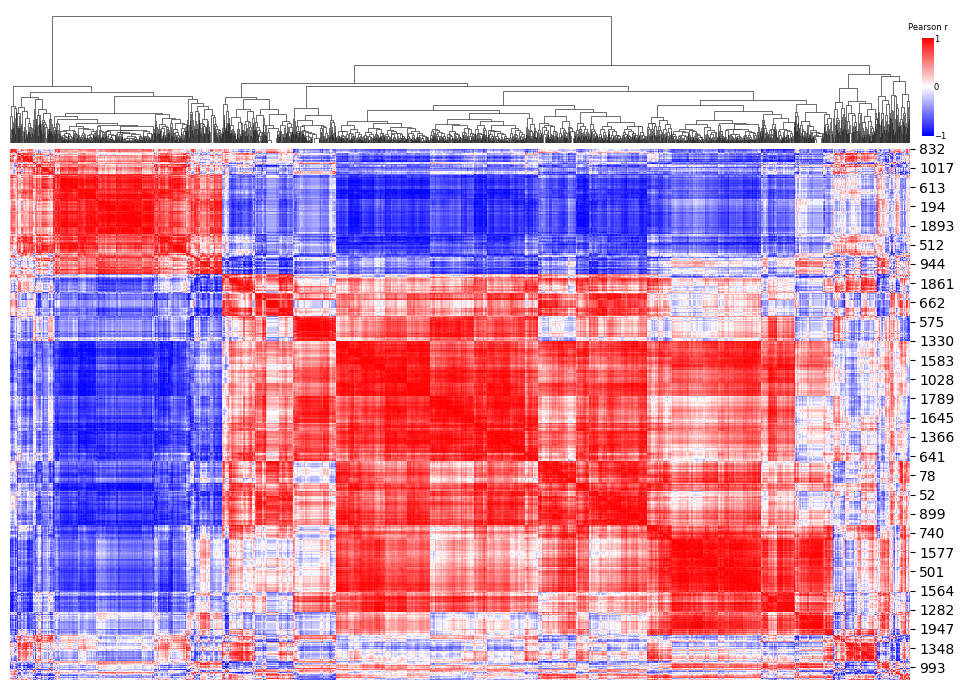

In [9]:
kws = dict(cbar_kws=dict(ticks=[-1,0,1]))
clustermap = sns.clustermap(corr, 
                            center=0, 
                            cmap='bwr', 
                            vmin=-1, vmax=1, 
                            figsize=(12,7), 
                            xticklabels=False, **kws)

clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_cbar.set_position([clustermap.ax_col_dendrogram.get_position().x1+0.01, # x location 
                                 clustermap.ax_col_dendrogram.get_position().y0+0.01, # y location
                                 0.01,                                                # width
                                 clustermap.ax_col_dendrogram.get_position().height-0.05]) #height
clustermap.ax_cbar.set_title('Pearson r',fontsize=6)
clustermap.cax.tick_params(axis='y', labelsize=6, length=0, pad=0.1) 
plt.show()

clustermap.figure.savefig(os.path.join(SAVE_PATH, "U2OS_codeword_idx_corr_heatmap.png"))

## Cut the dendrogram to get indices clusters

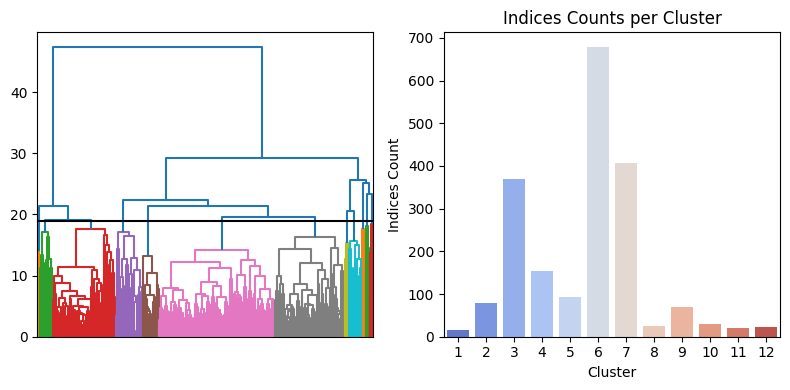

In [10]:
def get_clusters(clustermap, corr, cutoff = 14.2):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    den = scipy.cluster.hierarchy.dendrogram(clustermap.dendrogram_col.linkage,
                                             labels = corr.index,
                                             color_threshold=cutoff,
                                             no_labels=True,
                                             ax=axs[0])
    axs[0].axhline(cutoff, c='black', linestyle="-")
    #return den
    
    def get_cluster_classes(den):
        cluster_classes = defaultdict(list)
        seen = []
        cur_cluster = 1
        last_color = den['leaves_color_list'][0]
        for label, color in zip(den['ivl'], den['leaves_color_list']):
            if color != last_color:
                cur_cluster += 1
                last_color = color
            cluster_classes[cur_cluster].append(label)     
        return cluster_classes

    clusters = get_cluster_classes(den)
    cluster = []
    corr_with_clusters = corr.copy()

    for i in corr_with_clusters.index:
        included=False
        for j in clusters.keys():
            if i in clusters[j]:
                cluster.append(j)
                included=True
        if not included:
            cluster.append(None)

    corr_with_clusters["cluster"] = cluster

    # visualize the cluster counts
    sns.countplot(data=corr_with_clusters.sort_values(by='cluster'), x='cluster', palette='coolwarm', ax=axs[1])

    # Add labels and title
    axs[1].set_xlabel('Cluster')
    axs[1].set_ylabel('Indices Count')
    axs[1].set_title('Indices Counts per Cluster')

    plt.tight_layout()
    # Show
    plt.show()
    corr_with_clusters['cluster'] = corr_with_clusters['cluster'].astype(str)
    corr_with_clusters['cluster'] = 'C' + corr_with_clusters['cluster']
    return corr_with_clusters

corr_with_clusters = get_clusters(clustermap, corr, cutoff = 19)

## Find representative images per cluster

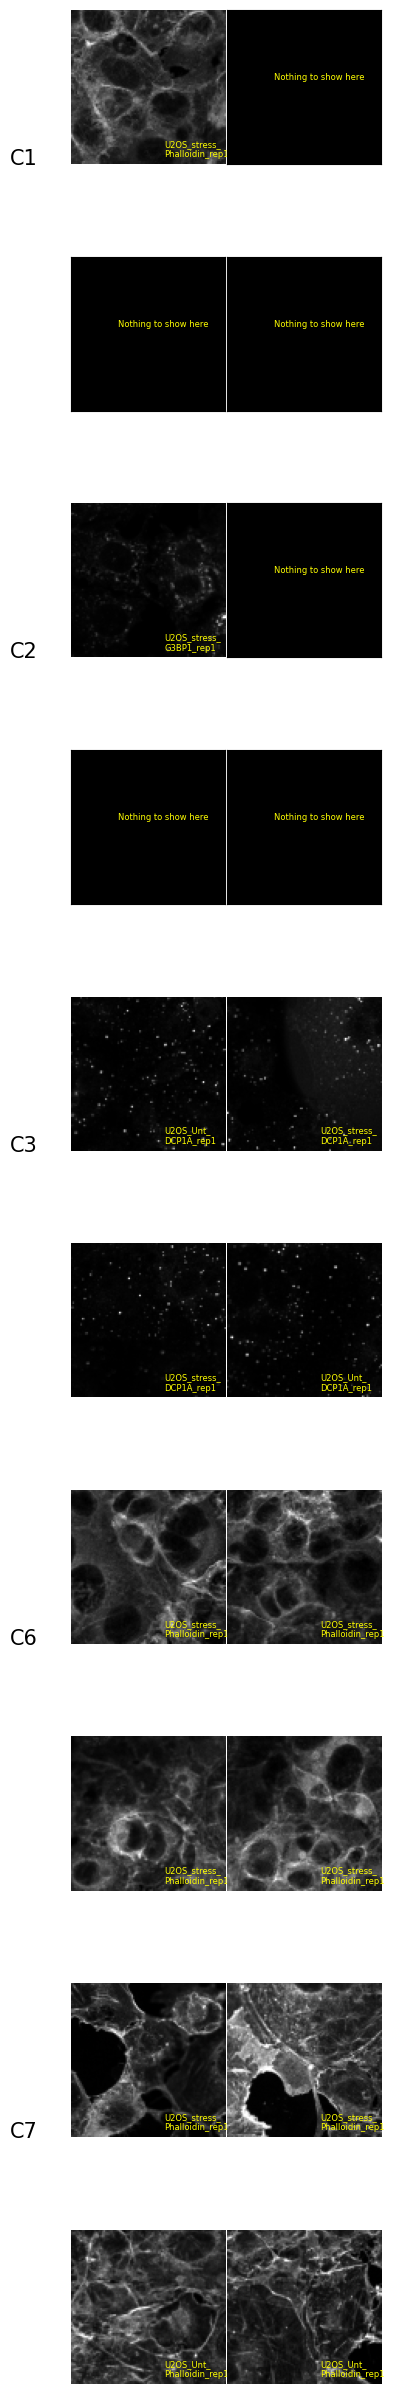

In [11]:
clusters = np.unique(corr_with_clusters.cluster)
hist_per_cluster = pd.DataFrame(index = hist_df_with_path.index, columns = list(clusters) + ['label','path'])
hist_per_cluster.label = hist_df_with_path.label
hist_per_cluster.path = hist_df_with_path.path

# for each cluster, get the indices and calc the sum of the histogram
for cluster_label, cluster_group in corr_with_clusters.groupby('cluster'):
    hist_per_cluster[cluster_label] = hist_df_with_path[cluster_group.index].sum(axis=1) / 625
    
hist_per_cluster['max_cluster'] = hist_per_cluster.idxmax(axis=1, numeric_only=True)
fig, axs = plt.subplots(nrows=2*np.unique(hist_per_cluster.max_cluster).size, ncols=2, figsize=(4,32))

unique_markers = np.unique(hist_per_cluster.label.str.split("_").str[0])
unique_cell_lines =  np.unique(hist_per_cluster.label.str.split("_").str[1])
unique_conditions =  np.unique(hist_per_cluster.label.str.split("_").str[2])
color_light_green = '#8DF980'
color_gray = 'gray'

unique_label_per_clusters = {}
unique_marker_per_clusters = pd.DataFrame(color_gray, columns=clusters, index=unique_markers)
unique_cell_lines_per_clusters = pd.DataFrame(color_gray,columns=clusters, index=unique_cell_lines)
unique_conditions_per_clusters = pd.DataFrame(color_gray,columns=clusters, index=unique_conditions)

for i, (max_cluster, max_cluster_group) in enumerate(hist_per_cluster.groupby('max_cluster')):
    max_cluster_group_thres = max_cluster_group[max_cluster_group[max_cluster] >= 0.5]
    unique_label_per_clusters[max_cluster] = np.unique(max_cluster_group_thres.label)
    unique_marker_per_clusters.loc[np.unique(max_cluster_group_thres.label.str.split("_").str[0]), max_cluster] = color_light_green
    unique_cell_lines_per_clusters.loc[np.unique(max_cluster_group_thres.label.str.split("_").str[1]), max_cluster]  = color_light_green
    unique_conditions_per_clusters.loc[np.unique(max_cluster_group_thres.label.str.split("_").str[2]), max_cluster]  = color_light_green
    max_tiles_paths = max_cluster_group[[max_cluster,'path']].sort_values(by=max_cluster,ascending=False)[:4].path
    max_tiles_paths = list(max_tiles_paths)
    delta = 4 - len(max_tiles_paths)
    if (delta>0):
        max_tiles_paths.extend([None]*delta)

    for j, tile_path in enumerate(max_tiles_paths):
        ax = axs[i * 2 + j // 2, j%2]
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        if tile_path is None: 
            ax.imshow(np.zeros((100,100)), cmap='gray')
            ax.text(30,45, "Nothing to show here", color='yellow', fontsize=6)
            continue
        else:
            cut = tile_path.rfind("_")
            real_path = tile_path[:cut]
            tile_number = int(tile_path[cut+1:])
            cur_site = np.load(real_path)
            ax.imshow(cur_site[tile_number,:,:,0], cmap='gray')
            
        ax.axis('off')
        if j==0:
            ax.text(-40,100, max_cluster, fontsize=15)
        split_path=real_path.split(os.sep)
        marker = split_path[-2]
        condition = split_path[-3]
        if 'Untreated' in condition:
            condition = condition[:3]
        cell_line = split_path[-4]
        if 'FUS' in cell_line:
            cell_line = cell_line[:6]
        rep = split_path[-1].split("_")[0]
        label = f"{cell_line}_{condition}_\n{marker}_{rep}"
        ax.text(60,95,label, color='yellow', fontsize=6)
    
plt.subplots_adjust(wspace=0.01, hspace=0.01)
# Save the figure to file
plt.savefig(os.path.join(SAVE_PATH, "U2OS_representative_images_per_cluster.png"), bbox_inches='tight')

plt.show()

## plot the heatmaps with clusters and histograms of wanted labels

In [12]:
def plot_heatmap_with_clusters_and_histograms(corr_with_clusters, hist_df, labels, 
                                              sep = "_", colormap_name = "viridis", 
                                              filename="codeword_idx_heatmap_and_histograms.png"):
    
    # create the heatmap and dendrogram
    kws = dict(cbar_kws=dict(ticks=[-1,0,1]))
    clustermap = sns.clustermap(corr, center=0, cmap='bwr', vmin=-1, vmax=1, figsize=(9,7), xticklabels=False, yticklabels=False, col_colors=corr_with_clusters.cluster, **kws)
    clustermap.ax_row_dendrogram.set_visible(False)

    # get the indices order from the dendrogram 
    hierarchical_order = clustermap.dendrogram_col.reordered_ind
    
    # prepare labels and filter histograms of wanted labels
    real_labels = []
    for label in labels:
        if label not in np.unique(hist_df.label):
            real_labels += [real_label for real_label in np.unique(hist_df.label) if label in real_label]
        else:
            real_labels.append(label)
    hist_df_cur = hist_df[hist_df.label.isin(real_labels)]
    cur_groups = real_labels
    splitted_labels = hist_df_cur.label.str.split(sep)
    cur_batches = np.unique(splitted_labels.str[-2])
    cur_markers = np.unique(splitted_labels.str[-5])
    cur_conditions = np.unique(splitted_labels.str[-3])
    cur_reps =  np.unique(splitted_labels.str[-1])

    # Mean the histograms by labels and re-order by the indices order
    total_spectra_per_marker_ordered = hist_df_cur.groupby('label').mean()[hierarchical_order] 

    # Set same y label limit for pairs to be compared
    tmp1 = pd.DataFrame(total_spectra_per_marker_ordered.max(axis=1)).reset_index()
    tmp1.columns = ['label', 'max']
    tmp1['label_s'] = tmp1['label'].str.split("_").apply(lambda x: '_'.join(x[:2] + x[3:]))
    tmp2 = tmp1.groupby('label_s').max()
    tmp2.columns = ['label', 'max']
    max_per_condition = tmp1[['label', 'label_s']].merge(tmp2['max'], right_index=True, left_on='label_s')

    # calc clusters locations
    #cluster_counts = pd.DataFrame(corr_with_clusters.cluster.value_counts()).reset_index().sort_values(by='cluster')
    cluster_counts = pd.DataFrame(corr_with_clusters.cluster.value_counts()).reset_index()#
    cluster_counts.cluster = cluster_counts.cluster.str.replace('C','').astype('int')
    cluster_counts.sort_values(by='cluster', inplace=True)
    cluster_positions = clustermap.ax_col_dendrogram.get_position()
    num_samples = len(clustermap.dendrogram_col.data)
    line_positions = [cluster_positions.x0 + i * (cluster_positions.width / num_samples) for i in range(1, num_samples)]

    # make room for the histograms in the plot
    hist_height = 0.05
    clustermap.fig.subplots_adjust(top=hist_height*len(cur_groups)+1, bottom=hist_height*len(cur_groups))

    # add axes for the histograms
    axs=[]
    for i, label in enumerate(cur_groups):
        axs.append(clustermap.fig.add_axes([clustermap.ax_heatmap.get_position().x0, 0+i*hist_height, clustermap.ax_heatmap.get_position().width, hist_height]))

    # create colors
    colors = {"Untreated": "#52C5D5", 'stress': "#F7810F"}

    # plot the histograms
    for i, label in enumerate(cur_groups[::-1]):
        d = total_spectra_per_marker_ordered.loc[label, :]
        if 'stress' in label: 
            my_color = colors['stress']
        else:
            my_color = colors['Untreated']
        axs[i].fill_between(range(len(d)), d, color=my_color, label=label, linewidth=1)
        axs[i].set_xticklabels([])
        axs[i].set_xticks([])
        # # Set same y label limit for pairs to be compared
        max_limit = max_per_condition.loc[max_per_condition['label']==label, 'max'].values[0]
        axs[i].set_ylim(0, max_limit+(0.25*max_limit))
        # axs[i].set_yticklabels([])
        # axs[i].set_yticks([])
        axs[i].tick_params(axis='y', labelsize=4, length=0, pad=0.1)
        splitted_label = label.split(sep)
        label_for_plot = ''
        if len(cur_conditions)>1:
            label_for_plot+= f'{splitted_label[-3]}_'  
        if len(cur_markers)>1:
            label_for_plot+= f'{splitted_label[-5]}_'
        if len(cur_batches)>1:
            label_for_plot+= f'{splitted_label[-2]}_'
        if len(cur_reps)>1:
            label_for_plot+= f'{splitted_label[-1]}'
        if label_for_plot.endswith("_"):
            label_for_plot = label_for_plot[:-1]
        axs[i].text(1.02, 0.5, label_for_plot, transform=axs[i].transAxes,
                    rotation=0, va='center', ha='left')
        # add cluster lines to histograms
        prev_count = 0
        for j, cluster in enumerate(cluster_counts.cluster):
            cur_count = cluster_counts.iloc[j]['count']
            cluster_end = cur_count + prev_count
            axs[i].axvline(x=cluster_end, color='black',linestyle="--", linewidth=0.4)
            prev_count = cluster_end

        #ax.tick_params(axis='y', labelsize=8)
        axs[i].spines['bottom'].set_color('lightgray')
        axs[i].spines['top'].set_color('lightgray')
        axs[i].spines['right'].set_color('lightgray')
        axs[i].spines['left'].set_color('lightgray')
        axs[i].margins(x=0)

    # fix the cbar appearance 
    clustermap.ax_cbar.set_position([clustermap.ax_col_dendrogram.get_position().x1+0.01, # x location 
                                     clustermap.ax_col_dendrogram.get_position().y0+0.01, # y location
                                     0.01,                                                # width
                                     clustermap.ax_col_dendrogram.get_position().height-0.05]) #height
    clustermap.ax_cbar.set_title('Pearson r',fontsize=6)
    clustermap.cax.tick_params(axis='y', labelsize=6, length=0, pad=0.1)
   
    # add cluster lines to the heatmap
    prev_count = 0
    for j, cluster in enumerate(cluster_counts.cluster):
        cur_count = cluster_counts.iloc[j]['count']
        cluster_end = cur_count + prev_count
        clustermap.ax_heatmap.axvline(x=cluster_end, color='black',linestyle="--", linewidth=0.4)
        clustermap.ax_col_colors.text(x=cluster_end-(cur_count/2), y=0.5, s=cluster, fontsize=6)
        prev_count = cluster_end
    
    clustermap.figure.savefig(os.path.join(SAVE_PATH, filename), bbox_inches='tight')
    
    return None

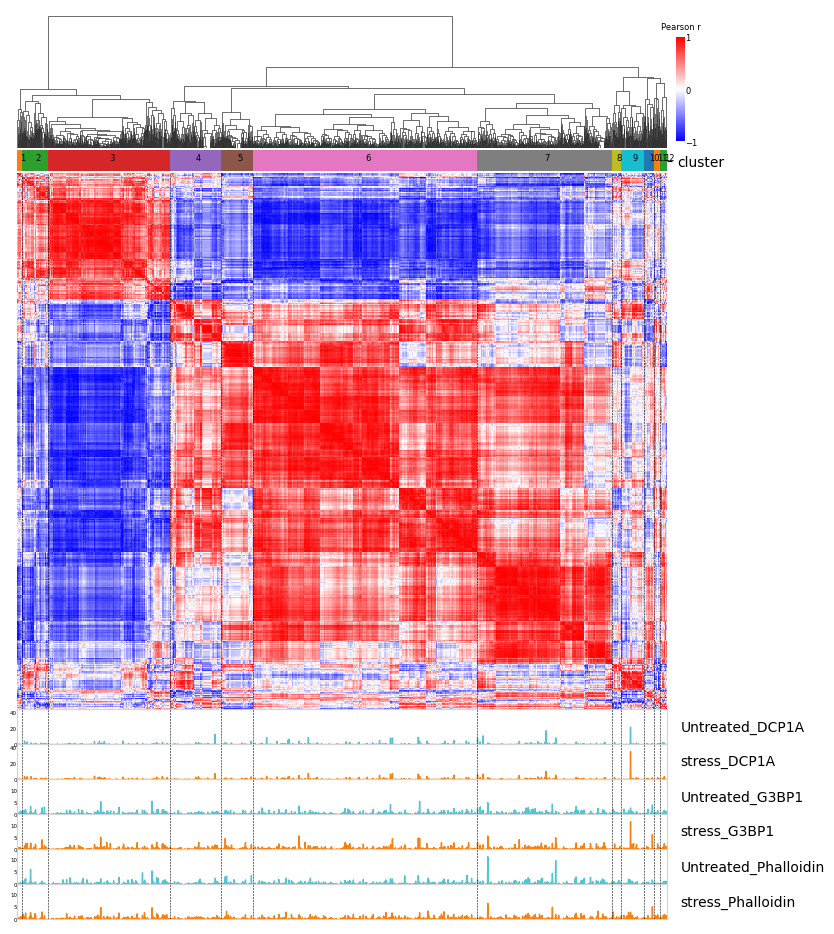

In [13]:
plot_heatmap_with_clusters_and_histograms(corr_with_clusters, 
                                          hist_df, 
                                          labels = [''],
                                          filename="U2OS_codeword_idx_heatmap_and_histograms.png")

In [14]:
def plot_delta_feature_spectra(corr_with_clusters, 
                               hist_df, labels, 
                               sep = "_", colormap_name = "viridis", 
                               filename="delta_feature_spectra.png"):
    
    # create the heatmap and dendrogram
    kws = dict(cbar_kws=dict(ticks=[-1,0,1]))
    clustermap = sns.clustermap(corr, center=0, cmap='bwr', vmin=-1, vmax=1, figsize=(9,7), xticklabels=False, yticklabels=False, col_colors=corr_with_clusters.cluster, **kws)
    clustermap.ax_row_dendrogram.set_visible(False)

    # get the indices order from the dendrogram 
    hierarchical_order = clustermap.dendrogram_col.reordered_ind
    
    # prepare labels and filter histograms of wanted labels
    real_labels = []
    for label in labels:
        if label not in np.unique(hist_df.label):
            real_labels += [real_label for real_label in np.unique(hist_df.label) if label in real_label]
        else:
            real_labels.append(label)
            
    hist_df_cur = hist_df[hist_df.label.isin(real_labels)]
    n_cur_groups = int(len(real_labels) / 2) # divided by 2 because we show delta feature spectra (pairs)
    splitted_labels = hist_df_cur.label.str.split(sep)
    cur_batches = np.unique(splitted_labels.str[-2])
    cur_markers = np.unique(splitted_labels.str[-5])
    cur_conditions = np.unique(splitted_labels.str[-3])
    cur_reps =  np.unique(splitted_labels.str[-1])

    # Mean the histograms by labels and re-order by the indices order
    total_spectra_per_marker_ordered = hist_df_cur.groupby('label').mean()[hierarchical_order] 

    # calc clusters locations
    cluster_counts = pd.DataFrame(corr_with_clusters.cluster.value_counts()).reset_index()#
    cluster_counts.cluster = cluster_counts.cluster.str.replace('C','').astype('int')
    cluster_counts.sort_values(by='cluster', inplace=True)
    cluster_positions = clustermap.ax_col_dendrogram.get_position()
    num_samples = len(clustermap.dendrogram_col.data)
    line_positions = [cluster_positions.x0 + i * (cluster_positions.width / num_samples) for i in range(1, num_samples)]

    # make room for the histograms in the plot
    hist_height = 0.05
    clustermap.fig.subplots_adjust(top=hist_height*n_cur_groups+1, bottom=hist_height*n_cur_groups)

    # add axes for the histograms
    axs=[]
    for i in range(0, n_cur_groups):
        axs.append(clustermap.fig.add_axes([clustermap.ax_heatmap.get_position().x0, 0+i*hist_height, clustermap.ax_heatmap.get_position().width, hist_height]))

    # create colors
    colors = sns.color_palette(colormap_name, n_colors=n_cur_groups)
    # ------------------------------------
    # Pairs to be compared
    list_of_pairs = list(set(total_spectra_per_marker_ordered.reset_index()['label'].str.split("_").apply(lambda x: '_'.join(x[:2] + x[3:]))))
    
    def add_condition_to_label(label, condition):
        l = label.split("_")
        l.insert(2, condition)
        return '_'.join(l)
        
    # plot the histograms
    for i, label in enumerate(list_of_pairs[::-1]):
        
        label1 = add_condition_to_label(label, condition='stress')
        label2 = add_condition_to_label(label, condition='Untreated')
        
        d1 = total_spectra_per_marker_ordered.loc[label1, :]
        d2 = total_spectra_per_marker_ordered.loc[label2, :]
        d = d1 - d2
        # Pairs to be compared
        # ------------------------------------
        axs[i].fill_between(range(len(d)), d, color=colors[i], label=label, linewidth=1)
        axs[i].margins(y=0.25)
        
        axs[i].set_xticklabels([])
        axs[i].set_xticks([])
        # axs[i].set_yticklabels([])
        # axs[i].set_yticks([])
        
        axs[i].tick_params(axis='y', labelsize=4, length=0, pad=0.1)
        splitted_label = label.split(sep)
        label_for_plot = ''
        if len(cur_markers)>1:
            label_for_plot+= f'{splitted_label[-4]}_'
        if len(cur_batches)>1:
            label_for_plot+= f'{splitted_label[-2]}_'
        if len(cur_reps)>1:
            label_for_plot+= f'{splitted_label[-1]}'
        if label_for_plot.endswith("_"):
            label_for_plot = label_for_plot[:-1]
        
        axs[i].text(1.02, 0.5, label_for_plot, transform=axs[i].transAxes,
                    rotation=0, va='center', ha='left')
        
        # add cluster lines to histograms
        prev_count = 0
        for j, cluster in enumerate(cluster_counts.cluster):
            cur_count = cluster_counts.iloc[j]['count']
            cluster_end = cur_count + prev_count
            axs[i].axvline(x=cluster_end, color='black',linestyle="--", linewidth=0.4)
            prev_count = cluster_end

        #ax.tick_params(axis='y', labelsize=8)
        axs[i].spines['bottom'].set_color('lightgray')
        axs[i].spines['top'].set_color('lightgray')
        axs[i].spines['right'].set_color('lightgray')
        axs[i].spines['left'].set_color('lightgray')
        axs[i].margins(x=0)

    # fix the cbar appearance 
    clustermap.ax_cbar.set_position([clustermap.ax_col_dendrogram.get_position().x1+0.01, # x location 
                                     clustermap.ax_col_dendrogram.get_position().y0+0.01, # y location
                                     0.01,                                                # width
                                     clustermap.ax_col_dendrogram.get_position().height-0.05]) #height
    clustermap.ax_cbar.set_title('Pearson r',fontsize=6)
    clustermap.cax.tick_params(axis='y', labelsize=6, length=0, pad=0.1)
   
    # add cluster lines to the heatmap
    prev_count = 0
    for j, cluster in enumerate(cluster_counts.cluster):
        cur_count = cluster_counts.iloc[j]['count']
        cluster_end = cur_count + prev_count
        clustermap.ax_heatmap.axvline(x=cluster_end, color='black',linestyle="--", linewidth=0.4)
        clustermap.ax_col_colors.text(x=cluster_end-(cur_count/2), y=0.5, s=cluster, fontsize=6)
        prev_count = cluster_end
    
    plt.suptitle("Delta Feature Spectra", x=0.5, y=1.2, color='red')
    
    clustermap.figure.savefig(os.path.join(SAVE_PATH, filename), bbox_inches='tight')
    
    return None

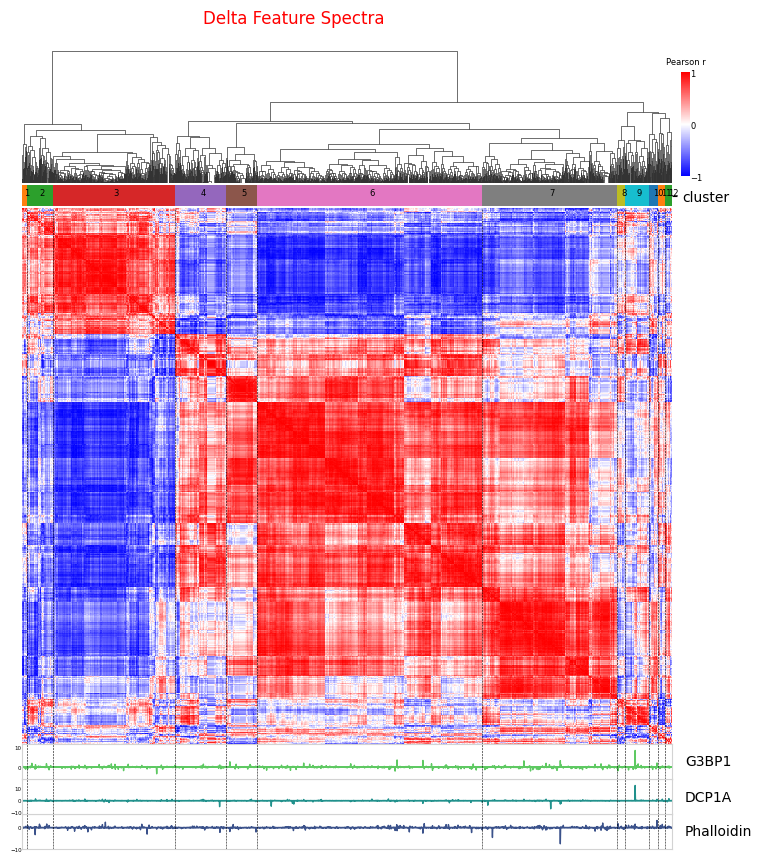

In [15]:
plot_delta_feature_spectra(corr_with_clusters, 
                           hist_df, 
                           labels = [''],
                           sep = "_", colormap_name = "viridis", 
                           filename="U2OS_delta_feature_spectra.png")

In [16]:
print("Done")

Done


## Done!